In [1]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from mlresearch.utils import set_matplotlib_style
from recgame.environments import BaseEnvironment
from recgame.recourse import DiCE

set_matplotlib_style(16)

# Some variables to define the problem
BIAS_FACTOR = .9
RNG_SEED = 20
rng = np.random.default_rng(RNG_SEED)
N_CONTINUOUS = 2
N_AGENTS = 100

# NOTE: Categorical feature will be the "groups" variable; immutable + categorical

# Environment variables
N_LOANS = 10
ADAPTATION = .5
NEW_AGENTS = 10

# Define functions

In [2]:
def get_scaler(n_agents=10_000, n_continuous=2, bias_factor=0, random_state=None):
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]
    
    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=0, scale=1/4, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=bias_factor, scale=1/4, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    return MinMaxScaler().fit(X)


In [3]:
scaler = get_scaler(
    n_agents=10_000, 
    n_continuous=N_CONTINUOUS, 
    bias_factor=BIAS_FACTOR, 
    random_state=rng
)

In [4]:
def biased_data_generator(n_agents, n_continuous=2, bias_factor=0, scaler=None, random_state=None):
    """
    groups feature: 
    - 0 -> Disadvantaged group
    - 1 -> Advantaged group
    
    ``bias_factor`` varies between [0, 1], 0 is completely unbiased, 1 is fully biased.
    """
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]

    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=0, scale=1/4, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=bias_factor, scale=1/4, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    
    # TEST: scale continuous features
    if scaler is not None:
        X.loc[:,:] = scaler.transform(X)
    
    X = pd.concat([X, groups], axis=1)
    X = np.clip(X, 0, 1)
    
    # Generate the target
    p1 = 0.5 * bias_factor + 0.5
    p0 = 1 - p1

    y0 = rng.binomial(1, p0, counts[0])
    y1 = rng.binomial(1, p1, counts[1])
    
    y = pd.concat(
        [
            pd.Series((y0 if val==0 else y1), index=group.index) 
            for val, group in X.groupby("groups")
        ]
    ).sort_index()

    return X, y

In [5]:
def env_biased_data_generator(n_agents):
    return biased_data_generator(n_agents, N_CONTINUOUS, BIAS_FACTOR, scaler, rng)[0]

In [6]:
class IgnoreGroupLR(LogisticRegression):
    def __init__(self, ignore_feature=None, **kwargs):
        super().__init__(**kwargs)
        self.ignore_feature = ignore_feature
    
    def _get_X(self, X):
        return X.copy() if self.ignore_feature is None else X.drop(columns=self.ignore_feature)
    
    def fit(self, X, y):
        """NOTE: X must be a pandas dataframe."""
        super().fit(self._get_X(X), y)
        return self

    def predict(self, X):
        return super().predict(self._get_X(X))
    
    def predict_proba(self, X):
        return super().predict_proba(self._get_X(X))

In [7]:
def fairness_metrics(environment, filter_feature="groups", bins=10, advantaged_pop=1):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"][filter_feature] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    # Get fairness analysis
    fairness_analysis = agents_info.dropna().groupby(filter_feature).mean()
    success_rates = environment.analysis.success_rate(filter_feature=filter_feature)
    fairness_analysis["avg_recourse_reliability"] = success_rates.mean()

    # Get disparity metrics
    not_advantaged = fairness_analysis.index[fairness_analysis.index != advantaged_pop]
    disparates = (fairness_analysis.loc[not_advantaged] / fairness_analysis.loc[advantaged_pop])
    disparates = disparates[["time_for_recourse", "avg_recourse_reliability"]]
    disparates.columns = [var for var in disparates.columns + "_disparity"]
    disparates["time_for_recourse_diff"] = (
        fairness_analysis.loc[not_advantaged, "time_for_recourse"] 
        - fairness_analysis.loc[advantaged_pop, "time_for_recourse"]
    )
    disparates.drop(columns="time_for_recourse_disparity", inplace=True)

    # Get Equality of Opportunity
    efforts = pd.concat(
        [environment.metadata_[step]["effort"] for step in environment.metadata_.keys()]
    )
    efforts = efforts.groupby(efforts.index).mean().rename("effort")
    agents_info = pd.concat([agents_info, efforts], axis=1)
    agents_info["effort_bins"] = pd.cut(agents_info["effort"], bins)

    def extract_info(df):
        avg_effort = df["effort"].mean()    
        outcome_rate = df["final_score"].dropna().shape[0] / df.shape[0]
        return pd.Series({"avg_effort": avg_effort, "outcome_rate": outcome_rate})

    eo = agents_info.groupby(["groups", "effort_bins"], group_keys=True).apply(extract_info)
    eo = eo.reset_index().groupby("groups", group_keys=True).apply(lambda df: (df["outcome_rate"] * df["avg_effort"]).sum() / df["avg_effort"].sum())
    disparates["EO"] = eo[not_advantaged] / eo[advantaged_pop]
    return disparates

# Experiments

In [8]:
df, y = biased_data_generator(N_AGENTS, N_CONTINUOUS, BIAS_FACTOR, scaler, rng)
categorical = ["groups"]

model = IgnoreGroupLR(categorical, random_state=RNG_SEED).fit(df, y)

In [9]:
model.coef_ = np.array([[2, 2]])
model.intercept_ = np.array([-1])

Original classes:
 groups   
0       0    47
        1     2
1       0     1
        1    50
dtype: int64
Predicted classes:
 groups   
0       0     3
        1    46
1       1    51
dtype: int64


<Axes: title={'center': 'f1'}, ylabel='Frequency'>

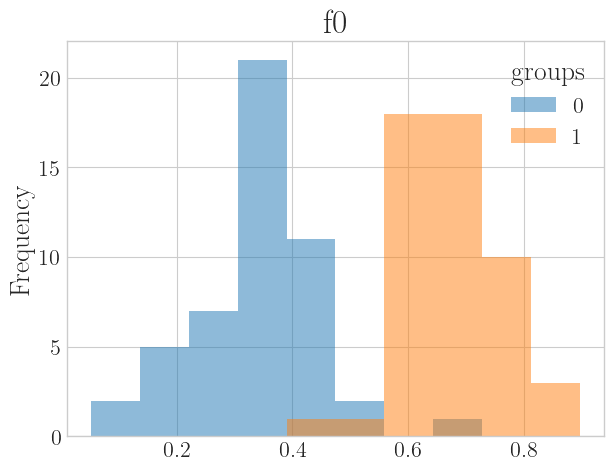

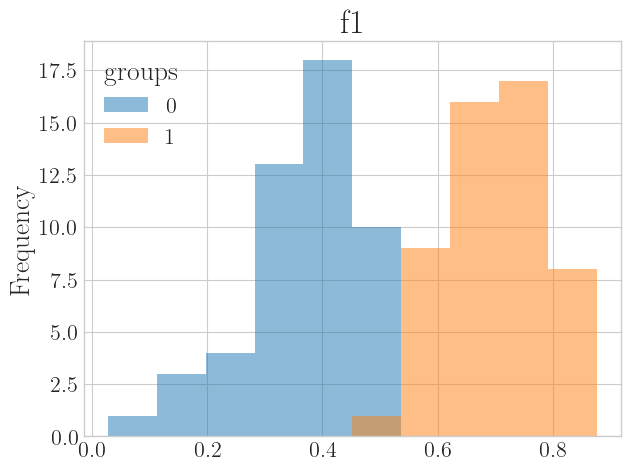

In [10]:
print("Original classes:\n", df.groupby(["groups", y]).size())
print("Predicted classes:\n", df.groupby(["groups", model.predict(df)]).size())
df.pivot(columns="groups")["f0"].plot(kind="hist", stacked=False, bins=10, alpha=0.5, title="f0")
df.pivot(columns="groups")["f1"].plot(kind="hist", stacked=False, bins=10, alpha=0.5, title="f1")

In [11]:
df.min(), df.max()

(f0        0.052523
 f1        0.027286
 groups    0.000000
 dtype: float64,
 f0        0.896320
 f1        0.876665
 groups    1.000000
 dtype: float64)

In [12]:
# Define the necessary components to run simulation
recourse = DiCE(model, categorical=["groups"], immutable=["groups"], random_state=RNG_SEED)
recourse.set_actions(df)
recourse.action_set_.lb = [-0.1, -0.1, 0]
recourse.action_set_.ub = [1.1, 1.1, 1]

environment = BaseEnvironment(
    X=df,
    recourse=recourse,
    data_source_func=env_biased_data_generator,
    threshold=N_LOANS,
    threshold_type="absolute",
    adaptation=ADAPTATION,
    behavior_function="continuous_constant",
    growth_rate=NEW_AGENTS,
    growth_rate_type="absolute",
    random_state=RNG_SEED,
)

environment.simulate(10)

/home/joaofonseca/miniconda3/envs/recourse-game/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "
100%|████████████| 90/90 [00:06<00:00, 14.42it/s]


BaseEnvironment(X=          f0        f1  groups
0   0.585407  0.743952       1
1   0.658393  0.561702       1
2   0.321290  0.458588       0
3   0.357525  0.494089       0
4   0.714601  0.622121       1
..       ...       ...     ...
95  0.723961  0.683356       1
96  0.208764  0.357282       0
97  0.571948  0.716660       1
98  0.351955  0.426222       0
99  0.712049  0.722130       1

[100 rows x 3 columns],
                adaptation=0.5, behavior_function='continuous_constant',
                data_source_func=<function env_biased_data_generator at 0x7f874d27bc70>,
                growth_rate=10, growth_rate_type='absolute', random_state=20,
                recourse=DiCE(categorical=['groups'], immutable=['groups'],
                              model=IgnoreGroupLR(ignore_feature=['groups']),
                              random_state=20, threshold=0.9006789305952541),
                threshold=10)

# Visualization and analysis

In [13]:
from matplotlib.colors import ListedColormap
environment.plot._favorable = ListedColormap(["#40b27f", "green"])
environment.plot._unfavorable = ListedColormap(["#51a3ef", "blue"])
environment.plot._previous = ListedColormap(["#be4d65", "red"])

<Axes: title={'center': 'Population scores over 11 time steps'}, xlabel='Step', ylabel='Score'>

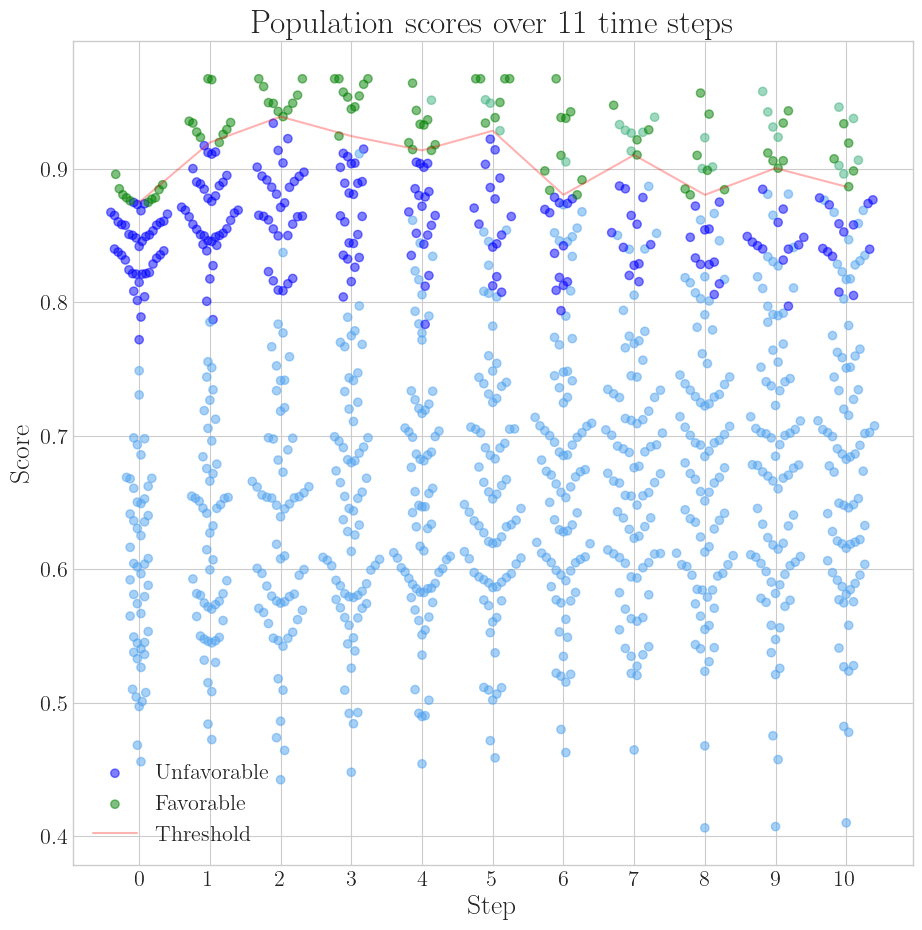

In [14]:
environment.plot.agent_scores(color_feature="groups")

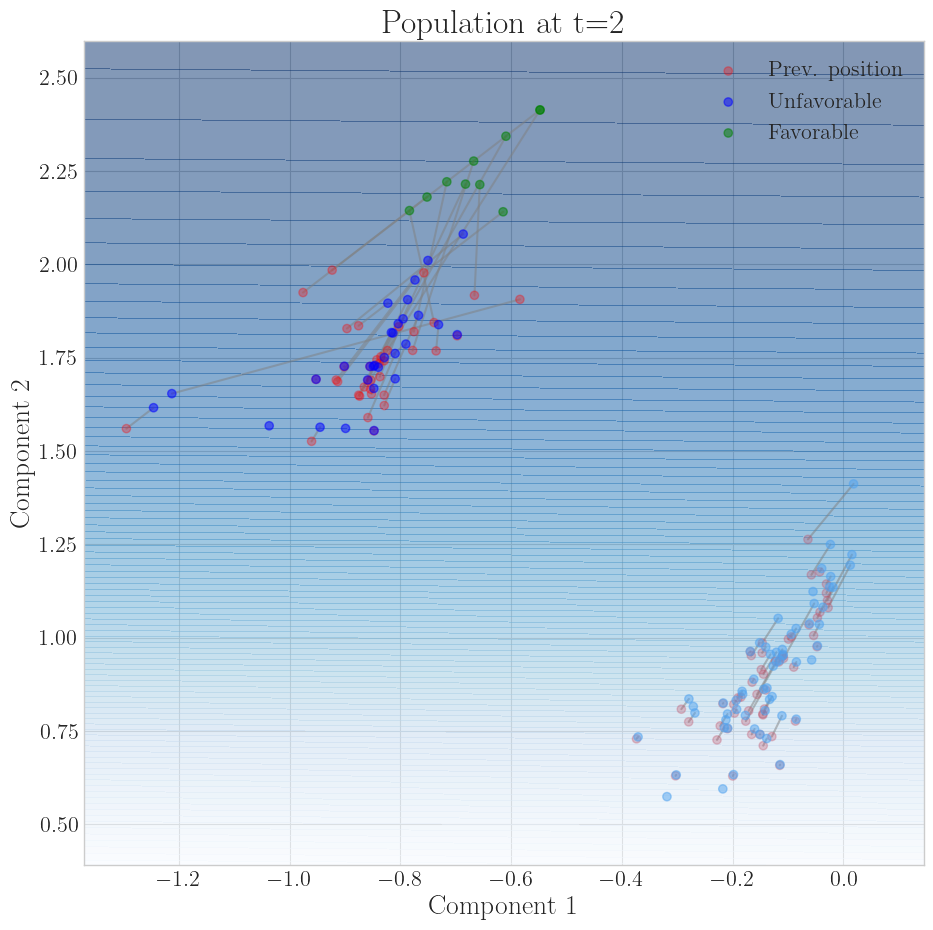

In [15]:
ax = environment.plot.scatter(2, color_feature="groups")

In [16]:
fairness_metrics(environment)

,avg_recourse_reliability_disparity,time_for_recourse_diff,EO
groups,,,
0,1.056676,4.683158,0.461706


# Draft code

In [17]:
BIAS_FACTOR

0.9

In [18]:
df

,f0,f1,groups
0,0.585407,0.743952,1
1,0.658393,0.561702,1
2,0.321290,0.458588,0
3,0.357525,0.494089,0
4,0.714601,0.622121,1
...,...,...,...
95,0.723961,0.683356,1
96,0.208764,0.357282,0
97,0.571948,0.716660,1
98,0.351955,0.426222,0


In [19]:
counts = Counter(df["groups"])

In [20]:
Counter(environment.X_.groups)

Counter({0: 82, 1: 18})

In [21]:
Counter(environment.get_all_agents().groups)

Counter({1: 100, 0: 100})